# Распознавание рукописного ввода на примере базы MNIST

Что делать

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную модель, за исключением сверточных нейронных сетей.

 

Критерии качества 

Метрика accuracy. Чтобы получить зачёт по работе работе, значение метрики должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

 

Как сдавать

Решение необходимо предоставить в виде ipytnon-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.


## Обработка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

RANDOM_SEED = 42

In [2]:
df_train = pd.read_csv('./data/digit/train.csv')
df_test = pd.read_csv('./data/digit/test.csv')

In [3]:
df_test.index = range(1,len(df_test)+1)

In [4]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print(df_train.shape)
print(df_test.shape)

(42000, 785)
(28000, 784)


In [6]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

In [8]:
sample_5 = df_train.sample(5, random_state=422)
sample_5_labels = sample_5.pop('label')

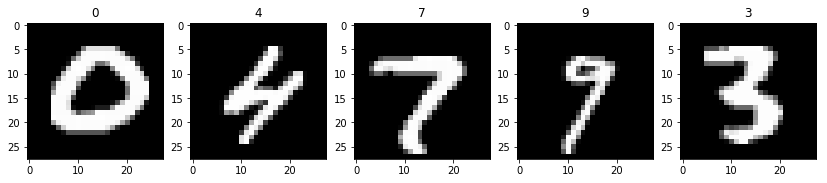

In [9]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(sample_5.values, 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img.reshape((28,28)), cmap='gray');
    subplot.set_title('%s' % sample_5_labels.values[i - 1]);

In [10]:
y = df_train.pop('label')
y.shape

(42000,)

In [11]:
#делаем стратифицированное разбиение на train и test
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.20, stratify=y, random_state=42)
print(X_train.shape)
print(y_train.shape)

(33600, 784)
(33600,)


## Baseline

### SVM

In [11]:
%%time
clf_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', random_state=42))
])
clf_svm.fit(X_train, y_train)
predict_train = clf_svm.predict(X_train)
predict_test = clf_svm.predict(X_test)
print('SVC rbf:')
print('Accuracy train: {0:6.4f}'.format(accuracy_score(y_train, predict_train)))
print('Accuracy test: {0:6.4f}'.format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

SVC rbf:
Accuracy train: 0.9839
Accuracy test: 0.9568
             precision    recall  f1-score   support

          0       0.98      0.97      0.98       826
          1       0.97      0.99      0.98       937
          2       0.92      0.97      0.94       835
          3       0.95      0.93      0.94       870
          4       0.96      0.96      0.96       814
          5       0.94      0.93      0.94       759
          6       0.98      0.97      0.98       828
          7       0.96      0.96      0.96       880
          8       0.96      0.94      0.95       813
          9       0.95      0.94      0.94       838

avg / total       0.96      0.96      0.96      8400

CPU times: user 12min 36s, sys: 867 ms, total: 12min 37s
Wall time: 12min 36s


### RandomForest

In [12]:
%%time
clf_rf = Pipeline([
#    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=42, n_jobs=-1))
])
clf_rf.fit(X_train, y_train)
predict_train = clf_rf.predict(X_train)
predict_test = clf_rf.predict(X_test)
print('RandomForestClassifier:')
print('Accuracy train: {0:6.4f}'.format(accuracy_score(y_train, predict_train)))
print('Accuracy test: {0:6.4f}'.format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

RandomForestClassifier:
Accuracy train: 0.9898
Accuracy test: 0.9561
             precision    recall  f1-score   support

          0       0.97      0.98      0.98       826
          1       0.98      0.99      0.98       937
          2       0.95      0.95      0.95       835
          3       0.95      0.92      0.94       870
          4       0.96      0.96      0.96       814
          5       0.93      0.94      0.94       759
          6       0.96      0.98      0.97       828
          7       0.97      0.96      0.97       880
          8       0.94      0.94      0.94       813
          9       0.94      0.94      0.94       838

avg / total       0.96      0.96      0.96      8400

CPU times: user 32.1 s, sys: 1.94 s, total: 34 s
Wall time: 9.26 s


### MLP

In [30]:
%%time
clf_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(hidden_layer_sizes=(20,20 ), activation='relu', solver='adam', random_state=42))
])
clf_mlp.fit(X_train, y_train)
predict_train = clf_mlp.predict(X_train)
predict_test = clf_mlp.predict(X_test)
print('MLPClassifier 20-20-10:')
print('Accuracy train: {0:6.4f}'.format(accuracy_score(y_train, predict_train)))
print('Accuracy test: {0:6.4f}'.format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

MLPClassifier 20-20-10:
Accuracy train: 0.9981
Accuracy test: 0.9449
             precision    recall  f1-score   support

          0       0.97      0.97      0.97       826
          1       0.97      0.98      0.98       937
          2       0.95      0.94      0.94       835
          3       0.91      0.94      0.92       870
          4       0.95      0.93      0.94       814
          5       0.94      0.92      0.93       759
          6       0.97      0.97      0.97       828
          7       0.94      0.95      0.95       880
          8       0.93      0.91      0.92       813
          9       0.92      0.93      0.92       838

avg / total       0.94      0.94      0.94      8400

CPU times: user 1min, sys: 6.59 s, total: 1min 6s
Wall time: 34 s


### Предварительный итог

У всех моделей на 784 базовых фичах наблюдается переобучение. SVM с нелинейным ядром показал хороший результат, но обучается долго. На базовом наборе фичей большой размерности лучший результат по скорости и точности у RandomForest.


## PCA преобразование

Text(0,0.5,'explained_variance_ratio_')

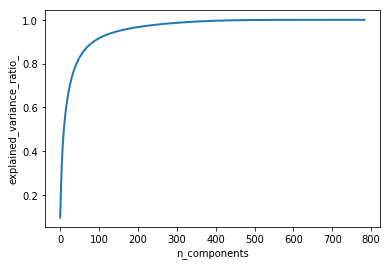

In [10]:
pca = PCA(random_state=42)
pca.fit(X_train)
plt.plot(pca.explained_variance_ratio_.cumsum(), linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')

Посмотрим, сколько признаков останется после PCA преобразования с сохранением 99% и 95% дисперсии

In [11]:
pca = PCA(0.99, random_state=42)
pca.fit_transform(X_train).shape

(33600, 330)

In [12]:
pca = PCA(0.95, random_state=42)
pca.fit_transform(X_train).shape

(33600, 153)

Добавим в pipeline базовых моделей PCA(0.99)

### SVM

In [13]:
%%time
clf_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(0.99, random_state=42, whiten=True)),
    ('clf', SVC(kernel='rbf', random_state=42))
])
clf_svm.fit(X_train, y_train)
predict_train = clf_svm.predict(X_train)
predict_test = clf_svm.predict(X_test)
print('SVC rbf, PCA:')
print('Accuracy train: {0:6.4f}'.format(accuracy_score(y_train, predict_train)))
print('Accuracy test: {0:6.4f}'.format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

SVC rbf, PCA:
Accuracy train: 0.9845
Accuracy test: 0.9264
             precision    recall  f1-score   support

          0       0.97      0.96      0.97       826
          1       0.98      0.99      0.98       937
          2       0.79      0.96      0.86       835
          3       0.92      0.89      0.91       870
          4       0.95      0.92      0.94       814
          5       0.92      0.90      0.91       759
          6       0.95      0.95      0.95       828
          7       0.94      0.91      0.92       880
          8       0.94      0.88      0.91       813
          9       0.93      0.91      0.92       838

avg / total       0.93      0.93      0.93      8400

CPU times: user 20min 43s, sys: 1.34 s, total: 20min 45s
Wall time: 20min 40s


### RandomForest

In [14]:
%%time
clf_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(0.99, random_state=42, whiten=True)),
    ('clf', RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=42, n_jobs=-1))
])
clf_rf.fit(X_train, y_train)
predict_train = clf_rf.predict(X_train)
predict_test = clf_rf.predict(X_test)
print('RandomForestClassifier, PCA:')
print('Accuracy train: {0:6.4f}'.format(accuracy_score(y_train, predict_train)))
print('Accuracy test: {0:6.4f}'.format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

RandomForestClassifier, PCA:
Accuracy train: 0.9941
Accuracy test: 0.9223
             precision    recall  f1-score   support

          0       0.95      0.97      0.96       826
          1       0.98      0.98      0.98       937
          2       0.90      0.93      0.92       835
          3       0.88      0.92      0.90       870
          4       0.92      0.92      0.92       814
          5       0.92      0.87      0.89       759
          6       0.94      0.96      0.95       828
          7       0.93      0.92      0.92       880
          8       0.92      0.86      0.89       813
          9       0.88      0.89      0.88       838

avg / total       0.92      0.92      0.92      8400

CPU times: user 2min 57s, sys: 3.3 s, total: 3min
Wall time: 54.2 s


### MLP



In [15]:
%%time
clf_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(0.99, random_state=42, whiten=True)),
    ('clf', MLPClassifier(hidden_layer_sizes=(20,20 ), activation='relu', solver='adam', random_state=42))
])
clf_mlp.fit(X_train, y_train)
predict_train = clf_mlp.predict(X_train)
predict_test = clf_mlp.predict(X_test)
print('MLPClassifier 20-20-10, PCA:')
print('Accuracy train: {0:6.4f}'.format(accuracy_score(y_train, predict_train)))
print('Accuracy test: {0:6.4f}'.format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

MLPClassifier 20-20-10, PCA:
Accuracy train: 0.9959
Accuracy test: 0.9054
             precision    recall  f1-score   support

          0       0.94      0.95      0.94       826
          1       0.95      0.97      0.96       937
          2       0.89      0.91      0.90       835
          3       0.89      0.89      0.89       870
          4       0.91      0.89      0.90       814
          5       0.87      0.86      0.86       759
          6       0.93      0.93      0.93       828
          7       0.91      0.90      0.91       880
          8       0.88      0.87      0.87       813
          9       0.88      0.88      0.88       838

avg / total       0.91      0.91      0.91      8400

CPU times: user 1min 4s, sys: 5.41 s, total: 1min 9s
Wall time: 35.3 s


### Подбор параметров

С помощью GridSearch подберем оптимильные параметры для pipeline с PCA и RandomForest.

In [27]:
clf_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(0.99, random_state=42, whiten=True)),
    ('clf', RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=42))
])
grid_params = [
    {'pca__n_components': [0.95, 0.99],
     'clf__n_estimators':[10, 50, 100],
     'clf__min_samples_leaf': [2, 5, 10],
     'clf__max_depth':[5, 10, 15],
     
    }]

In [28]:
%%time
grid = GridSearchCV(clf_rf, param_grid=grid_params, cv=3, n_jobs=-1, scoring='accuracy', verbose=1, refit=True)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed: 44.0min finished


CPU times: user 2min 49s, sys: 1.89 s, total: 2min 51s
Wall time: 45min 14s


In [29]:
print(grid.best_estimator_)
print('Accuracy на cv: {0:6.4f}'.format(grid.best_score_))
predict_train = grid.predict(X_train)
predict_test = grid.predict(X_test)
print('Accuracy train: {0:6.4f}'.format(accuracy_score(y_train, predict_train)))
print('Accuracy test: {0:6.4f}'.format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=42,
  svd_solver='auto', tol=0.0, whiten=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            ...timators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])
Accuracy на cv: 0.9204
Accuracy train: 0.9980
Accuracy test: 0.9252
             precision    recall  f1-score   support

          0       0.95      0.97      0.96       826
          1       0.98      0.98      0.98       937
          2       0.91      0.92      0.92       835
          3       0.88      0.91      0.90       870
          4       0.93      0.92      0.92       814
          5       0.92      0.88      0.90       759
          6       0.95      0.96      0.96       828
          7       0.94      0.93      0.93       880
          8       0.91

готовим предсказание и делаем первый submit

In [56]:
model = grid.best_estimator_
model.fit(df_train, y)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=42,
  svd_solver='auto', tol=0.0, whiten=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            ...timators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))])

In [57]:
y_pred = model.predict(df_test)
y_pred = pd.Series(y_pred, index=df_test.index)

In [58]:
y_pred.head()

1    2
2    0
3    4
4    2
5    3
dtype: int64

In [59]:
y_pred.to_csv('predictions1.csv', sep=',', header=True, index_label=['ImageId','Label'])

## HOG признаки

In [12]:
import cv2

строим дескриптор HOG для всего изображения 28x28, гистограммы градиентов считаем для ячеек 7x7, нормализуем блоками 14x14 со страйдом 7x7.

итого, в одном блоке 9x4=36 бинов, всего блоков 3x3=9. Получаем 9x36=324 фичи в дескрипторе

In [13]:
winSize = (28,28)
blockSize = (14,14)
blockStride = (7,7)
cellSize = (7,7)
nbins = 9
 
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

In [14]:
sample_5 = sample_5.astype(np.uint8)

In [33]:
sample_5_hog = np.array([hog.compute(row.reshape(28,28)).flatten() for row in sample_5.values])

In [34]:
sample_5_hog.shape

(5, 324)

In [35]:
X_train = X_train.astype(np.uint8)
X_test = X_test.astype(np.uint8)

In [36]:
%%time
X_train_hog = np.array([hog.compute(row.reshape(28,28)).flatten() for row in X_train.values])
X_test_hog = np.array([hog.compute(row.reshape(28,28)).flatten() for row in X_test.values])
print(X_train_hog.shape)
print(X_test_hog.shape)

(33600, 324)
(8400, 324)
CPU times: user 2.73 s, sys: 0 ns, total: 2.73 s
Wall time: 2.73 s


### SVM

In [37]:
%%time
clf_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', random_state=42))
])
clf_svm.fit(X_train_hog, y_train)
predict_train = clf_svm.predict(X_train_hog)
predict_test = clf_svm.predict(X_test_hog)
print('SVC rbf, HOG:')
print('Accuracy train: {0:6.4f}'.format(accuracy_score(y_train, predict_train)))
print('Accuracy test: {0:6.4f}'.format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

SVC rbf, HOG:
Accuracy train: 0.9975
Accuracy test: 0.9921
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       826
          1       0.99      1.00      0.99       937
          2       0.99      1.00      0.99       835
          3       1.00      0.99      0.99       870
          4       1.00      0.99      0.99       814
          5       0.99      0.99      0.99       759
          6       1.00      1.00      1.00       828
          7       0.99      0.99      0.99       880
          8       0.99      0.99      0.99       813
          9       0.98      0.99      0.99       838

avg / total       0.99      0.99      0.99      8400

CPU times: user 2min 26s, sys: 72.5 ms, total: 2min 26s
Wall time: 2min 26s


### RandomForest

In [38]:
%%time
clf_rf = Pipeline([
#    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=42, n_jobs=-1))
])
clf_rf.fit(X_train_hog, y_train)
predict_train = clf_rf.predict(X_train_hog)
predict_test = clf_rf.predict(X_test_hog)
print('RandomForestClassifier, HOG:')
print('Accuracy train: {0:6.4f}'.format(accuracy_score(y_train, predict_train)))
print('Accuracy test: {0:6.4f}'.format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

RandomForestClassifier, HOG:
Accuracy train: 0.9965
Accuracy test: 0.9789
             precision    recall  f1-score   support

          0       0.98      0.99      0.99       826
          1       0.99      0.98      0.98       937
          2       0.97      0.98      0.98       835
          3       0.98      0.97      0.97       870
          4       0.98      0.99      0.98       814
          5       0.98      0.98      0.98       759
          6       0.99      0.99      0.99       828
          7       0.97      0.98      0.98       880
          8       0.97      0.97      0.97       813
          9       0.97      0.96      0.97       838

avg / total       0.98      0.98      0.98      8400

CPU times: user 1min 50s, sys: 1.43 s, total: 1min 52s
Wall time: 30.2 s


### MLP

In [39]:
%%time
clf_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', MLPClassifier(hidden_layer_sizes=(20,20 ), activation='relu', solver='adam', random_state=42))
])
clf_mlp.fit(X_train_hog, y_train)
predict_train = clf_mlp.predict(X_train_hog)
predict_test = clf_mlp.predict(X_test_hog)
print('MLPClassifier 20-20-10, HOG:')
print('Accuracy train: {0:6.4f}'.format(accuracy_score(y_train, predict_train)))
print('Accuracy test: {0:6.4f}'.format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

MLPClassifier 20-20-10, HOG:
Accuracy train: 0.9990
Accuracy test: 0.9818
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       826
          1       0.98      0.99      0.99       937
          2       0.98      0.98      0.98       835
          3       0.99      0.97      0.98       870
          4       0.99      0.98      0.98       814
          5       0.98      0.98      0.98       759
          6       0.99      0.99      0.99       828
          7       0.99      0.97      0.98       880
          8       0.97      0.98      0.97       813
          9       0.96      0.98      0.97       838

avg / total       0.98      0.98      0.98      8400

CPU times: user 29.5 s, sys: 939 ms, total: 30.5 s
Wall time: 15.3 s


### Подбор параметров

С помощью GridSearch подберем оптимильные параметры для SVM на HOG признаках.

In [43]:
clf_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', SVC(kernel='rbf', random_state=42))
])
grid_params = [
    {'clf__kernel':['rbf', 'poly'],
     'clf__C': [0.01, 0.1, 1, 10, 100],
    }]

In [45]:
%%time
grid = GridSearchCV(clf_svm, param_grid=grid_params, cv=3, n_jobs=-1, scoring='accuracy', verbose=1, refit=True)
grid.fit(X_train_hog, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 65.8min finished


CPU times: user 1min 15s, sys: 1.43 s, total: 1min 17s
Wall time: 1h 6min 54s


In [46]:
print(grid.best_estimator_)
print('Accuracy на cv: {0:6.4f}'.format(grid.best_score_))
predict_train = grid.predict(X_train_hog)
predict_test = grid.predict(X_test_hog)
print('Accuracy train: {0:6.4f}'.format(accuracy_score(y_train, predict_train)))
print('Accuracy test: {0:6.4f}'.format(accuracy_score(y_test, predict_test)))
print(classification_report(y_test, predict_test))

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))])
Accuracy на cv: 0.9906
Accuracy train: 1.0000
Accuracy test: 0.9925
             precision    recall  f1-score   support

          0       0.99      1.00      1.00       826
          1       1.00      1.00      1.00       937
          2       0.99      1.00      0.99       835
          3       1.00      0.99      0.99       870
          4       1.00      1.00      1.00       814
          5       0.99      0.99      0.99       759
          6       1.00      0.99      1.00       828
          7       0.99      0.99      0.99       880
          8       0.99      0.99      0.99       813
          9       0.98      0.99      0.99       838

avg / tota

готовим предсказание и делаем второй submit

In [47]:
%%time
X_train = df_train.astype(np.uint8)
X_test = df_test.astype(np.uint8)
X_train_hog = np.array([hog.compute(row.reshape(28,28)).flatten() for row in X_train.values])
X_test_hog = np.array([hog.compute(row.reshape(28,28)).flatten() for row in X_test.values])
print(X_train_hog.shape)
print(X_test_hog.shape)

(42000, 324)
(28000, 324)
CPU times: user 4.56 s, sys: 24.1 ms, total: 4.59 s
Wall time: 4.43 s


In [48]:
model = grid.best_estimator_
model.fit(X_train_hog, y)
y_pred = model.predict(X_test_hog)
y_pred = pd.Series(y_pred, index=df_test.index)

In [49]:
y_pred.head()

1    2
2    0
3    9
4    0
5    3
dtype: int64

In [50]:
y_pred.to_csv('predictions2.csv', sep=',', header=True, index_label=['ImageId','Label'])

In [51]:
# leaderboard score 0.99285